<b>Google Colab</b> <a href="https://colab.research.google.com/github/kirillzyusko/deeplearning/blob/master/4/lab.ipynb">link</a>

# **Introduction**

In the beginning of this lab I wanted to complete it using YOLO alghorithm. However, when I read more resources I found proposed neural network architecture, that I should try to use. So I stick with this option.

<div style="align-items: center; justify-content: center">
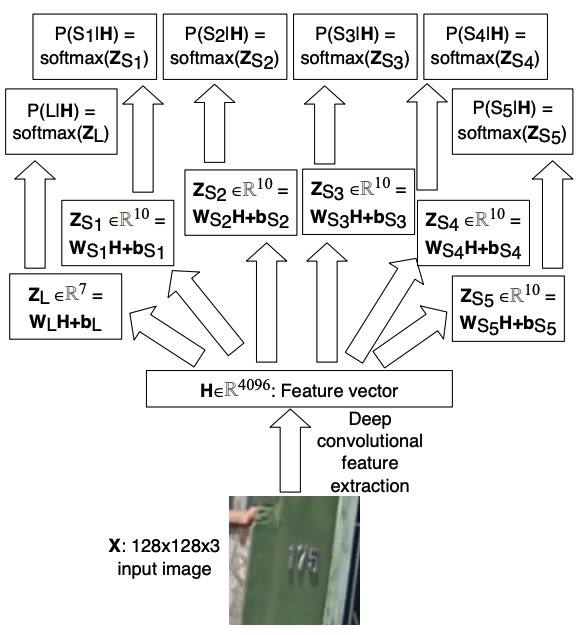</img>
<i style="align-items: center; justify-content: center">Picture 1 - proposed architecture of a neural network</i>
</div>

# **Part 1-1: Download and extract SVNH dataset**

Publication: https://arxiv.org/abs/1312.6082

In [0]:
!wget "http://ufldl.stanford.edu/housenumbers/train_32x32.mat"
!wget "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
!wget "http://ufldl.stanford.edu/housenumbers/extra_32x32.mat"

In [2]:
!wget "http://ufldl.stanford.edu/housenumbers/train.tar.gz"
!wget "http://ufldl.stanford.edu/housenumbers/test.tar.gz"
# !wget "http://ufldl.stanford.edu/housenumbers/extra.tar.gz"

--2020-03-14 20:43:15--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M  16.6MB/s    in 23s     

2020-03-14 20:43:44 (16.5 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]

--2020-03-14 20:43:47--  http://ufldl.stanford.edu/housenumbers/test.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276555967 (264M) [application/x-gzip]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>] 263.74M  19.9MB/s    in 17s     

2020-03-14 20:44:04 (15.1 MB/s) - ‘test.tar.gz’ saved [276555967/2

Extract .zip

In [0]:
!mkdir train
!mkdir test
#!mkdir extra
!tar xvzf train.tar.gz -C train
!tar xvzf test.tar.gz -C test
#!tar xvzf extra.tar.gz -C extra

In [4]:
%ls

sample_data/  test/  test.tar.gz  train/  train.tar.gz


Read data:

In [0]:
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
extra = loadmat('extra_32x32.mat')

X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

Check the data:

In [0]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (32, 32, 3, 73257)
y_train.shape:  (73257, 1)
X_test.shape:  (32, 32, 3, 26032)
y_test.shape:  (26032, 1)


Since we now know the structure of the data, we can visulize it:

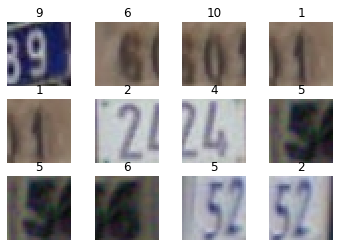

In [0]:
import matplotlib.pyplot as plt

X_train = X_train[:,:,:,:]
X_test = X_test[:,:,:,:]

start = 50

fig, ax = plt.subplots(3, 4)
for row in range(3):
    for col in range(4):
        ax[row, col].imshow(X_train[:,:,:,start+row*3+col])
        ax[row, col].axis('off')
        ax[row, col].set_title('{}'.format(y_train[start+row*3+col, 0]))
plt.show()

# **Common const definition:**

In [0]:
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

batch_size=32

In [0]:
import matplotlib.pyplot as plt

def show_images_with_labels(image_batch,label_batch,batch_size=batch_size):
    plt.figure(figsize=(10,10))
    for n in range(batch_size):
        ax = plt.subplot(4,8,n+1)
        plt.imshow(image_batch[n])
        length=label_batch[0][n]
        title=''.join([str(label_batch[c+1][n]) for c in range(length)])
        plt.title(title)
        plt.axis('off')

# **Part 1-2: Download and extract MNIST dataset**

In [0]:
from keras.datasets import mnist


# the data, split between train and test sets
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Normalizing the input
x_train_mnist= x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1) / 255
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0],28,28,1) / 255

Using TensorFlow backend.


Helper function:

In [0]:
import numpy as np
import cv2

def x_to_nn_input(X):
    x = np.reshape(X, (X.shape[0], 28, 28))
    x = np.asarray([cv2.resize(i, (IMAGE_WIDTH,IMAGE_HEIGHT)) for i in x], dtype=np.float32)
    x = np.repeat(x[..., np.newaxis], 3, -1)
    return x

In [0]:
x_to_nn_input(x_train_mnist[0:100]).shape

(100, 128, 128, 3)

Conversion for y value:

In [0]:
def y_mnist_to_NN_architecture_output(y):
  arr = [np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])]
  for i in range(6):
      for j in range(y.shape[0]):
          if i == 0:
              arr[0] = np.append(arr[0], int(1))
          if i == 1:
              arr[1] = np.append(arr[1], int(y[j]))
          if i >= 2:
              arr[i] = np.append(arr[i], int(NOT_A_NUMBER))
  return [i.astype(int) for i in arr]

In [0]:
y_mnist_to_NN_architecture_output(y_train_mnist)[0:32]

[array([1, 1, 1, ..., 1, 1, 1]),
 array([5, 0, 4, ..., 5, 6, 8]),
 array([10, 10, 10, ..., 10, 10, 10]),
 array([10, 10, 10, ..., 10, 10, 10]),
 array([10, 10, 10, ..., 10, 10, 10]),
 array([10, 10, 10, ..., 10, 10, 10])]

# **Part 1-3: Build a NN model**

NN model

In [89]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

input=Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), name="input")

H=Conv2D(16,(3,3),activation='relu',padding='same')(input)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same')(H)
H=Dropout(0.25)(H)

H=Conv2D(32,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same',strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(48,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same')(H)
H=Dropout(0.25)(H)

H=Conv2D(64,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same',strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(128,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same')(H)
H=Dropout(0.25)(H)

H=Conv2D(16,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same',strides=1)(H)
H=Dropout(0.25)(H)

H=Conv2D(16,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same')(H)
H=Dropout(0.25)(H)

H=Conv2D(16,(3,3),activation='relu',padding='same')(H)
H=BatchNormalization()(H)
H=MaxPooling2D(padding='same',strides=1)(H)
H=Dropout(0.25)(H)

H=Flatten()(H)      
hidden10=Dense(4096, activation='relu')(H)
#H=Dropout(0.25)(H)
#hidden10=Dense(4096, activation='relu')(H)
#hidden10=Dropout(0.25)(H)

length=Dense(6, activation='softmax', name='length')(hidden10)
digit1=Dense(11, activation='softmax', name='digit1')(hidden10)
digit2=Dense(11, activation='softmax', name='digit2')(hidden10)
digit3=Dense(11, activation='softmax', name='digit3')(hidden10)
digit4=Dense(11, activation='softmax', name='digit4')(hidden10)
digit5=Dense(11, activation='softmax', name='digit5')(hidden10)

model = Model(inputs=input, outputs=[length,digit1,digit2,digit3,digit4,digit5], name='svhn_model')

model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

model.summary()

Model: "svhn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 16)   448         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 64, 64, 16)   64          conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 32, 32, 16)   0           batch_normalization_14[0][0]     
_________________________________________________________________________________________

# **Part 1: Train on mnist dataset**

Const definition:

In [0]:
MAX_LENGTH = 5
NOT_A_NUMBER = 10

Data generator:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=8, 
    width_shift_range=0.08, 
    shear_range=0.3, 
    height_shift_range=0.08, 
    zoom_range=0.08,
    rescale=1./255
)
test_gen = ImageDataGenerator(rescale=1./255)

training_set= train_gen.flow(
    x_to_nn_input(x_train_mnist), 
    y_mnist_to_NN_architecture_output(y_train_mnist), 
    batch_size=32
)

test_set= train_gen.flow(
    x_to_nn_input(x_test_mnist),
    y_mnist_to_NN_architecture_output(y_test_mnist),
    batch_size=32
 )

Show resized images:

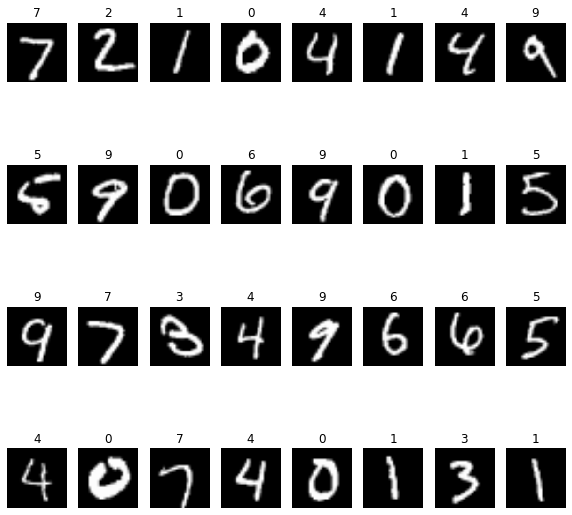

In [0]:
#image_batch, label_batch = next(train_gen)
show_images_with_labels(x_to_nn_input(x_test_mnist[0:32])[0:32], y_mnist_to_NN_architecture_output(y_test_mnist)[0:32])

NN train

In [0]:
X = x_to_nn_input(x_train_mnist[0:5000])
y = y_mnist_to_NN_architecture_output(y_train_mnist[0:5000])
Xt = x_to_nn_input(x_train_mnist[0:1000])
yt = y_mnist_to_NN_architecture_output(y_train_mnist[0:1000])

history = model.fit(
    X,
    y,
    validation_data=(Xt, yt),
    epochs=5,
    verbose=2
)

Train on 5000 samples, validate on 1000 samples
Epoch 1/5
5000/5000 - 22s - loss: 8.3469 - length_loss: 0.0048 - digit1_loss: 8.1836 - digit2_loss: 0.0204 - digit3_loss: 0.0216 - digit4_loss: 0.0426 - digit5_loss: 0.0366 - length_acc: 0.9980 - digit1_acc: 0.5320 - digit2_acc: 0.9940 - digit3_acc: 0.9938 - digit4_acc: 0.9936 - digit5_acc: 0.9936 - val_loss: 1742.6465 - val_length_loss: 0.0000e+00 - val_digit1_loss: 1723.5981 - val_digit2_loss: 0.0000e+00 - val_digit3_loss: 0.0000e+00 - val_digit4_loss: 0.0000e+00 - val_digit5_loss: 0.0000e+00 - val_length_acc: 1.0000 - val_digit1_acc: 0.1170 - val_digit2_acc: 1.0000 - val_digit3_acc: 1.0000 - val_digit4_acc: 1.0000 - val_digit5_acc: 1.0000
Epoch 2/5
5000/5000 - 20s - loss: 0.7481 - length_loss: 6.7513e-04 - digit1_loss: 0.7494 - digit2_loss: 9.6639e-04 - digit3_loss: 9.9039e-04 - digit4_loss: 9.5926e-04 - digit5_loss: 0.0010 - length_acc: 1.0000 - digit1_acc: 0.7660 - digit2_acc: 1.0000 - digit3_acc: 1.0000 - digit4_acc: 1.0000 - digit5

# **Part 2: Train on svnh dataset**

Dataset preprocessing:

In [91]:
import h5py
import pandas as pd
import numpy as np

# The DigitStructFile is just a wrapper around the h5py data. It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struct data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    # getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self, n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    # bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self, attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    # Return a restructured version of the dataset.
    #
    #   Return a list of such dicts:
    #      'filename': filename of the samples
    #      'labels': list of such digits presented by an 6-array
    #
    # Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure(self):
        labels = []
        filenames=[]

        for i in range(len(self.digitStructBbox)):
            bbox = self.digitStructBbox[i].item()
            label_attribute = self.inf[bbox]['label']
            label = self.bboxHelper(label_attribute)
            # since one of the numbers has 6 numbers! (it is > 5)
            label = [0 if digit == 10 else digit for digit in label]
            length = len(label)
            name = self.getName(i)

            if (length > MAX_LENGTH):
                continue

            for _ in range(MAX_LENGTH - length):
                label.append(NOT_A_NUMBER)
            label.append(length)

            labels.append(label)
            filenames.append(name)

        return np.array(filenames), np.array(labels).astype(int)

    def to_dataframe(self):
        filenames, labels = self.getAllDigitStructure()

        return pd.DataFrame({
          'filename': filenames,
          'length': labels[:,5],
          'digit1': labels[:,0],
          'digit2': labels[:,1],
          'digit3': labels[:,2],
          'digit4': labels[:,3],
          'digit5': labels[:,4]
      })


df = DigitStructFile('train/train/digitStruct.mat').to_dataframe()

df.tail()

,filename,length,digit1,digit2,digit3,digit4,digit5
33396,33398.png,1,8,10,10,10,10
33397,33399.png,1,8,10,10,10,10
33398,33400.png,2,9,5,10,10,10
33399,33401.png,2,2,2,10,10,10
33400,33402.png,3,1,6,9,10,10


Display one of the image:

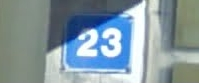

In [0]:
from IPython.display import Image

Image('train/train/2.png')

Dataset split

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size=0.10)

Image generator:

In [98]:
from keras.preprocessing.image import ImageDataGenerator

# use data augmentation
train_datagen_aug = ImageDataGenerator(
      rotation_range=10,
      rescale=1./255,
      shear_range=0.1,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1
)

test_gen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


Data flows:

In [123]:
TRAIN_PATH = 'processed/train/train'
TEST_PATH = 'processed/test/test'

y_col = ['length', 'digit1', 'digit2', 'digit3', 'digit4', 'digit5']
total_train = train.shape[0]
total_validate = val.shape[0]
batch_size = 32  # since Andrew Ng told, that better use 2^n

train_generator = train_datagen_aug.flow_from_dataframe(
    train, 
    TRAIN_PATH, 
    x_col='filename',
    y_col=y_col,
    target_size=IMAGE_SIZE,
    class_mode='multi_output',
    batch_size=batch_size
)

val_generator = test_gen.flow_from_dataframe(
    val, 
    TRAIN_PATH, 
    x_col='filename',
    y_col=y_col,
    target_size=IMAGE_SIZE,
    class_mode='multi_output',
    batch_size=batch_size
)

Found 30060 validated image filenames.
Found 3341 validated image filenames.


Show these examples:

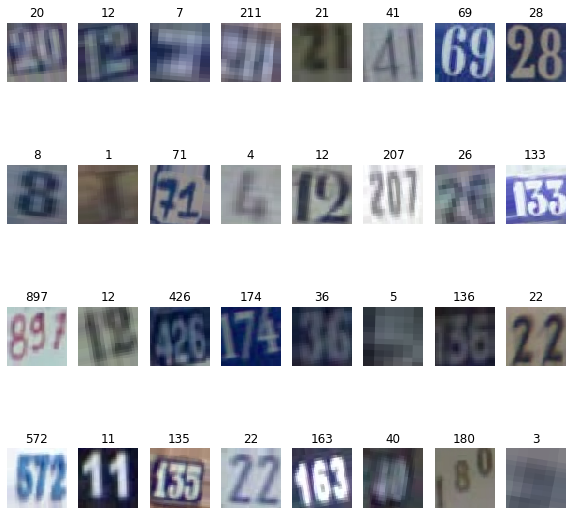

In [101]:
image_batch, label_batch = next(train_generator)
show_images_with_labels(image_batch, label_batch)

Train NN:

Download **model.h5** file:

In [0]:
!rm model.h5

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%ls 

drive/  extra.tar.gz  test/        train/
extra/  sample_data/  test.tar.gz  train.tar.gz


In [0]:
from tensorflow.keras.models import load_model

model = load_model("drive/My Drive/model-extra.h5")

In [102]:
from tensorflow.keras.callbacks import ModelCheckpoint

# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit_generator(
    train_generator, 
    epochs=20,
    validation_data=val_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks_list
)

Epoch 1/20
104/939 [==>...........................] - ETA: 17s - loss: 4.1588 - length_loss: 0.3912 - digit1_loss: 1.3012 - digit2_loss: 1.4722 - digit3_loss: 0.7709 - digit4_loss: 0.2202 - digit5_loss: 0.0030 - length_acc: 0.8558 - digit1_acc: 0.5685 - digit2_acc: 0.5003 - digit3_acc: 0.7488 - digit4_acc: 0.9519 - digit5_acc: 0.9997
Epoch 00001: loss improved from inf to 5.85611, saving model to model.h5
939/939 [==============================] - 68s 72ms/step - loss: 5.8577 - length_loss: 0.6889 - digit1_loss: 1.8455 - digit2_loss: 2.0290 - digit3_loss: 1.0504 - digit4_loss: 0.2361 - digit5_loss: 0.0078 - length_acc: 0.7122 - digit1_acc: 0.3541 - digit2_acc: 0.3013 - digit3_acc: 0.7052 - digit4_acc: 0.9555 - digit5_acc: 0.9987 - val_loss: 4.1588 - val_length_loss: 0.3912 - val_digit1_loss: 1.3012 - val_digit2_loss: 1.4722 - val_digit3_loss: 0.7709 - val_digit4_loss: 0.2202 - val_digit5_loss: 0.0030 - val_length_acc: 0.8558 - val_digit1_acc: 0.5685 - val_digit2_acc: 0.5003 - val_digit

KeyboardInterrupt: ignored

Applying test set processing

In [124]:
df_test = DigitStructFile('test/test/digitStruct.mat').to_dataframe()

test_generator = test_gen.flow_from_dataframe(
    df_test, 
    TEST_PATH, 
    x_col='filename',
    y_col=y_col,
    target_size=IMAGE_SIZE,
    class_mode='multi_output',
    batch_size=batch_size
)

Found 13068 validated image filenames.


In [125]:
results = model.evaluate(test_generator)

409/409 [==============================] - 7s 16ms/step - loss: 1.0949 - length_loss: 0.1493 - digit1_loss: 0.3433 - digit2_loss: 0.3860 - digit3_loss: 0.1829 - digit4_loss: 0.0317 - digit5_loss: 0.0017 - length_acc: 0.9480 - digit1_acc: 0.8981 - digit2_acc: 0.8870 - digit3_acc: 0.9482 - digit4_acc: 0.9922 - digit5_acc: 0.9998


In [126]:
print('Len acc: ', results[7])
print('Dig1 acc: ', results[8])
print('Dig2 acc: ', results[9])
print('Dig3 acc: ', results[10])
print('Dig4 acc: ', results[11])
print('Dig5 acc: ', results[12])

Len acc:  0.9479645
Dig1 acc:  0.8981481
Dig2 acc:  0.8869758
Dig3 acc:  0.9481941
Dig4 acc:  0.99219465
Dig5 acc:  0.99984694


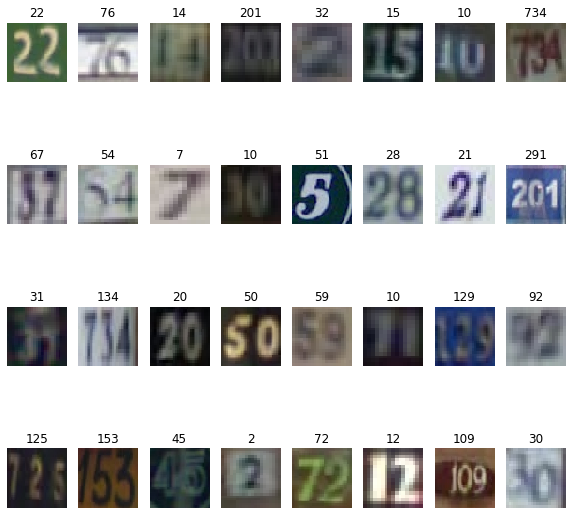

In [127]:
image_batch, label_batch = next(test_generator)

predict=model.predict(image_batch)

predicted_length=np.argmax(predict[0], axis=-1)
predicted_digit1=np.argmax(predict[1], axis=-1)
predicted_digit2=np.argmax(predict[2], axis=-1)
predicted_digit3=np.argmax(predict[3], axis=-1)
predicted_digit4=np.argmax(predict[4], axis=-1)
predicted_digit5=np.argmax(predict[5], axis=-1)

predicted_label=[predicted_length,predicted_digit1,predicted_digit2,predicted_digit3,predicted_digit4,predicted_digit5]

show_images_with_labels(image_batch, predicted_label)

# **PART 2-2: new crop alghoritm**

In [0]:
import os
import cv2
import h5py
import math
import numpy as np
from PIL import Image
from scipy import misc
import random as rand
from operator import add
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches
import pickle as pickle

In [0]:
training_directory = "train/train/"
training_filenames = []
# Note that training_filenames is 0-indexed, but that there is no 0.png
# so, x.png = training_filenames[x-1]
for i in range(1, 33403):
    training_filenames.append(str(i)+'.png')

testing_directory = "test/test/"
testing_filenames = []
# Note that testing_filenames is 0-indexed, but that there is no 0.png
# so, x.png = testing_filenames[x-1]
for i in range(1, 13069):
    testing_filenames.append(str(i)+'.png')

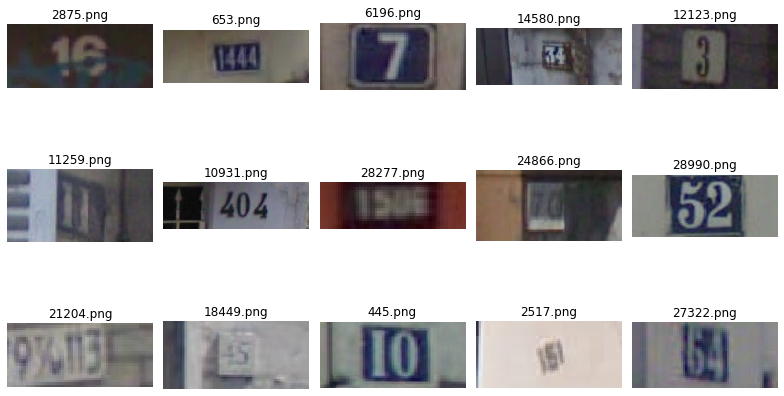

In [14]:
fig = plt.figure(figsize=(11, 7))
i = 1
rows = 3
columns = 5
for c in np.random.choice(len(training_filenames), rows * columns):
    img = mpimg.imread(training_directory + training_filenames[c])
    fig.add_subplot(rows, columns, i)
    i += 1
    plt.title(training_filenames[c])
    plt.axis("off")
    plt.imshow(img)
plt.tight_layout()
plt.show()

In [0]:
def read_metadata(train=True):
    if train:
        directory = training_directory
        fn = "train_metadata.pickle"
    else:
        directory = testing_directory
        fn = "test_metadata.pickle"
    
    # Load the given MatLab file
    f = h5py.File(directory + 'digitStruct.mat', 'r') 
    
    # Create our empty dictionary
    metadata= {}
    metadata['height'] = []
    metadata['label'] = []
    metadata['left'] = []
    metadata['top'] = []
    metadata['width'] = []
    
    # define a function to pass to h5py's visititems() function
    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        metadata[name].append(vals)
    
    # Add information to metadata
    for item in f['/digitStruct/bbox']:
        f[item[0]].visititems(print_attrs)

    return metadata

In [0]:
training_metadata = read_metadata(train=True)
testing_metadata = read_metadata(train=False)

In [0]:
train_l = training_metadata['label']
test_l = testing_metadata['label']

Problem:

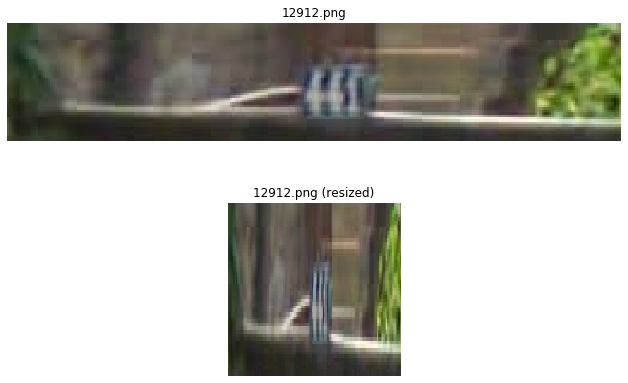

In [36]:
fig = plt.figure(figsize=(11, 7))
i = 12912

fig.add_subplot(211)
plt.axis("off")
plt.title(str(i) + ".png")
img = mpimg.imread(training_directory + training_filenames[i-1])
plt.imshow(img)

fig.add_subplot(212)
plt.axis("off")
img = Image.open(training_directory + training_filenames[i-1]).resize(IMAGE_SIZE)
plt.title(str(i) + ".png (resized)")
plt.imshow(img)
plt.show()

In [0]:
def getBBox(i, train=True):
    '''
    Given i, the desired i.png, returns
    x_min, y_min, x_max, y_max,
    the four numbers which define the small rectangular bounding
    box that contains all individual character bounding boxes
    '''
    if train:
        metadata = training_metadata
    else:
        metadata = testing_metadata
    
    x_min = min(metadata['left'][i-1])
    y_min = min(metadata['top'][i-1])
    x_max = max(map(add, metadata['left'][i-1], metadata['width'][i-1]))
    y_max = max(map(add, metadata['top'][i-1], metadata['height'][i-1]))
    return x_min, y_min, x_max, y_max

In [0]:
def cropBBox(img, x_min, y_min, x_max, y_max):
    '''
    Given a numpy array representing an image, and
    the four boundaries of the bounding box, returns
    the cropped bounding box, as
    x_min, y_min, x_max, y_max
    '''
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img.size[1], x_max)
    y_max = min(img.size[0], y_max)
    return x_min, y_min, x_max, y_max

In [0]:
def expandBBox(x_min, y_min, x_max, y_max):
    '''
    Given the four boundaries of the bounding box, returns
    those boundaries expanded out from the centroid by 30%, as
    x_min, y_min, x_max, y_max
    '''
    # The delta will be 30% of the width or height, (integer) halved
    x_d = ((x_max - x_min) * 0.3) // 2
    y_d = ((y_max - y_min) * 0.3) // 2
    return x_min - x_d, y_min - y_d, x_max + x_d, y_max + y_d

In [0]:
def getResized(f, train=True):
    '''
    Given an open file f, representing the desired image file,
    and a boolean representing whether this is a training image
    or a testing image,
    returns a numpy array, which is the portion of the
    image enclosed by the bounding box around all digits,
    resized to:
    64 pixels by 64 pixels if train=True,
    54 pixels by 54 pixels if train=False
    '''
    # Read the file as a numpy array
    img = Image.open(f)
    
    i = int(f.split('/')[2].split('.')[0])

    x_min, y_min, x_max, y_max = getBBox(i, train)
    cropped_img = img.crop((x_min, y_min, x_max, y_max)).resize(IMAGE_SIZE)
    cropped_img.save('processed/' + f)
    # Return the cropped, resized numpy array
    return cropped_img

12912


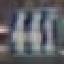

In [85]:
getResized('train/train/12912.png')

In [0]:
!mkdir -p processed/train/train

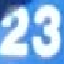

In [96]:
Image.open('processed/train/train/2.png')

In [0]:
for i in df['filename'].items():
    getResized('train/train/' + i[1])

In [0]:
!mkdir -p processed/test/test

In [0]:
for i in df_test['filename'].items():
    getResized('test/test/' + i[1], train=False)

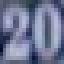

In [122]:
Image.open('processed/test/test/12.png')

# **Part 3: Test on own images**

Check on google images:

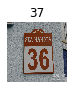

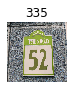

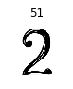

In [128]:
import cv2
import numpy as np
import requests

def predict_by_URL(url):
    resp = requests.get(url, stream=True).raw
    image = np.asarray(bytearray(resp.read()), dtype="uint8")

    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (IMAGE_WIDTH,IMAGE_HEIGHT))

    predict=model.predict(np.array([image]))

    predicted_length=np.argmax(predict[0], axis=-1)
    predicted_digit1=np.argmax(predict[1], axis=-1)
    predicted_digit2=np.argmax(predict[2], axis=-1)
    predicted_digit3=np.argmax(predict[3], axis=-1)
    predicted_digit4=np.argmax(predict[4], axis=-1)
    predicted_digit5=np.argmax(predict[5], axis=-1)

    predicted_label=[predicted_length,predicted_digit1,predicted_digit2,predicted_digit3,predicted_digit4,predicted_digit5]

    show_images_with_labels(np.array([image]), predicted_label, 1)

predict_by_URL('https://realt.by/uploads/tx_uedbhouses/Belarus/5102/1301116904/36/eed358d58c54a818.jpg')
predict_by_URL('https://realt.by/uploads/tx_uedbhouses/Belarus/5102/1205/52/ee87296a4baa3f83.jpg')
predict_by_URL('https://data.ac-illust.com/data/thumbnails/63/63661cf7a3df52dce5e2c8d0419c20e5_t.jpeg')

# **Part 4: Export model to tensorflow lite**

Convert model to tensorflow lite, in order to use it on weak devices:

In [0]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model_file('model.h5') 
tfmodel = converter.convert() 
open("model.tflite", "wb").write(tfmodel)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 64 variables.
INFO:tensorflow:Converted 64 variables to const ops.


84766588

Upload original model to google-drive:

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'model-70.h5'})
uploaded.SetContentFile('model.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1450MdoTihgsfv0O6Z1tNKbAXUoTSyX_T


# **Afterward. Test result**

Write here about my results. Attach various screenshots.

# **Resources**

- Publication from youtube link: https://arxiv.org/abs/1312.6082
- https://github.com/penny4860/Yolo-digit-detector
- https://github.com/dyckia/SVHN-CNN/blob/master/SVHN.ipynb